In [26]:
import pandas as pd
import os
from matplotlib import pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
plt.rcParams["font.sans-serif"] = "Helvetica"
plt.rcParams["font.family"] = "sans-serif"
sns.set(font="Helvetica")
USER = os.environ["USER"]
ROOT = os.path.dirname(os.path.dirname(os.path.abspath(USER)))

In [27]:
def get_conditioning(row):
    conditioning = []
    if row["use_rtg"]:
        conditioning.append("rtg")
    if row["use_mission"]:
        conditioning.append("mission")
    if row["use_feedback"]:
        if row["feedback_mode"] != "all":
            conditioning.append(f"{row['feedback_mode']} feedback")
        else:
            conditioning.append("all feedback")
    return " + ".join(conditioning)

In [28]:
def get_experiments(output_path, dir):
    settings = dir.split("-")[5:]
    dfs = []
    for seed_dir in os.listdir(os.path.join(output_path, dir)):
        exp_path = os.path.join(output_path, os.path.join(dir, seed_dir))
        try:
            df = pd.read_pickle(os.path.join(exp_path, "results.pkl"))
            df["model_seed"] = seed_dir
        except:
            continue
        for s in settings:
            key = s.split("_")[:-1]
            key ="_".join(key)
            value = s.split("_")[-1]
            value = int(value) if value.isnumeric() else (True if value == "True" else (False if value == "False" else value))
            df[key] = value
        try:
            df["conditioning"] = df.apply(lambda row: get_conditioning(row), axis=1)
        except KeyError:
            raise KeyError("Could not generate conditioning column")
        dfs.append(df)  
    return dfs

In [29]:
def get_combined_df(output_path):
    dfs = []
    for dir in os.listdir(output_path):
        if "level" in dir:
            current_dfs = get_experiments(output_path, dir)
            dfs.extend(current_dfs)
    dfs = [df[(df["eval_type"] != "efficiency") & (df["model"] == "DT")] for df in dfs]
    return pd.concat(dfs, ignore_index=True)

In [30]:
def aggr_results(df, eval_type, metric, ood_type=False):
    if eval_type == "ood_generalisation" and ood_type:
        results_df = df[df["eval_type"] == eval_type][["conditioning", "ood_type", metric]].groupby(["conditioning", "ood_type"]).agg(Mean=(metric, 'mean'), Std=(metric, 'std'), Min=(metric, 'min'), Max=(metric, 'max')).sort_values("Mean", ascending=False)
    else:
        results_df = df[df["eval_type"] == eval_type][["conditioning", metric]].groupby("conditioning").agg(Mean=(metric, 'mean'), Std=(metric, 'std'), Min=(metric, 'min'), Max=(metric, 'max')).sort_values("Mean", ascending=False)
        results_df["ood_type"] = None
    results_df["eval_type"] = eval_type
    return results_df

def get_deltas(df, reference):
    df.reset_index(inplace=True)
    delta_df = df[(df["conditioning"].str.contains(reference)) | (df["conditioning"] == "all feedback")]
    delta_df["Delta (Mean)"] = delta_df.apply(lambda row: row["Mean"] - delta_df.loc[delta_df["conditioning"] == reference, "Mean"].values[0], axis=1)
    delta_df["reference"] = reference
    return delta_df

def combine_results(df, metric):
    dfs = []
    for reference in ["mission", "rtg"]:
        for eval_type in df["eval_type"].unique():
            results = aggr_results(df, eval_type, metric)
            results_with_deltas = get_deltas(results, reference)
            dfs.append(results_with_deltas)
            if eval_type == "ood_generalisation":
                results2 = aggr_results(df, eval_type, metric, ood_type=True)
                results2_with_deltas = get_deltas(results2, reference)
                dfs.append(results2_with_deltas)
    return pd.concat(dfs, ignore_index=True)

In [31]:
def save_results_as_csv(df, level, metric, output_path):
    path = os.path.join(output_path,f"results_{level}_{metric}.csv")
    df.to_csv(path)

In [32]:
def map_colors(df, colors):
    labels = list(df["conditioning"].unique())
    return {label: colors["uoe_si_colors"][i+1] if "mission" in label else (colors["hwu_colors"][0] if label == "all feedback" else colors["aarg_colors"][i]) for i, label in enumerate(labels)}

def set_reference_performance_on_y_axis(ax, reference, reference_perf, ylims):
    ax.set_ylim(bottom=-ylims, top=ylims)
    yticklabels = ax.get_yticks().tolist()
    new_yticklabels = [f"{reference_perf:.2f}" if float(ytick) == float(0) else (f"+{ytick:.2f}" if float(ytick) > float(0) else f"{ytick:.2f}") for ytick in yticklabels]
    ax.set_yticklabels(new_yticklabels, fontsize=10)
    plt.text(-0.65, 0.0075, reference, fontsize=10, fontweight='bold', ha="right", va="center")

def set_bar_values(ax, df, ylims):
    for index, value in enumerate(df["Delta (Mean)"]):
        x_pos = index
        y_pos = value + ylims/25 if value > 0 else value - ylims/25
        va = "bottom" if value > 0 else "top"
        ax.text(x_pos, y_pos, f"{value:.2f}", ha='center', va=va, fontsize=10)

def set_pad_title(level, metric, eval_type):
    plt.title(f"'{level}' {metric.replace('_', ' ') + ' rate' if ('success' in metric and not 'rate' in metric) else ''} {eval_type.replace('_', ' ')}", fontsize=14, pad=14)
    
def set_pad_axis_labels(reference):
    plt.xticks(fontsize=10)
    plt.xlabel("Conditioning variant", fontsize=12, labelpad=14)
    plt.ylabel(f"Δ goal-conditioned success rate (vs. {reference} only)", fontsize=12, labelpad=18)

def set_margins():
    plt.margins(x=0.05, y=0.05)

def plot_deltas(df, level, metric, colors, ylims, eval_type, output_path, reference, reference_perf, ood_type=None):
    color_palette = map_colors(df, colors)
    eval_type = eval_type + " " + ood_type if ood_type else eval_type
    _, ax = plt.subplots(figsize=(10, 10))
    sns.barplot(data=df, x="conditioning", y="Delta (Mean)", ax=ax, errorbar=None, palette=color_palette)
    set_reference_performance_on_y_axis(ax, reference, reference_perf, ylims)
    set_bar_values(ax, df, ylims)
    set_pad_title(level, metric, eval_type)
    set_pad_axis_labels(reference)
    set_margins()
    plt.savefig(os.path.join(output_path, f"{level}_{metric}_{eval_type}_{reference}.png"))
    plt.show()

def plot_results(df, level, metric, colors, output_path):
    ylims = max(abs(df["Delta (Mean)"].max()), abs(df["Delta (Mean)"].min())) * 1.2
    for reference in ["mission", "rtg"]:
        for eval_type in df["eval_type"].unique():
            for ood_type in df[df["eval_type"] == eval_type]["ood_type"].unique():
                if ood_type is None:
                    results_with_ref = df[(df["eval_type"] == eval_type) & (df["reference"] == reference) & (pd.isnull(df["ood_type"]))]
                else:
                    results_with_ref = df[(df["eval_type"] == eval_type) & (df["reference"] == reference) & (df["ood_type"] == ood_type)]
                reference_perf = results_with_ref[results_with_ref["conditioning"] == reference]["Mean"].values[0]
                results = results_with_ref[~df["conditioning"].isin(["mission", "rtg"])]
                results.sort_values("conditioning", inplace=True)
                display(results)
                plot_deltas(results, level, metric, colors, ylims, eval_type, output_path, reference, reference_perf=reference_perf, ood_type=ood_type)

,conditioning,Mean,Std,Min,Max,ood_type,eval_type,Delta (Mean),reference
3,all feedback,0.269531,0.420453,0.0,1.0,None,iid_generalisation,-0.117188,mission
2,mission + all feedback,0.300781,0.449584,0.0,1.0,None,iid_generalisation,-0.085938,mission
1,mission + rule feedback,0.367188,0.467378,0.0,1.0,None,iid_generalisation,-0.019531,mission
4,mission + task feedback,0.257812,0.430091,0.0,1.0,None,iid_generalisation,-0.128906,mission


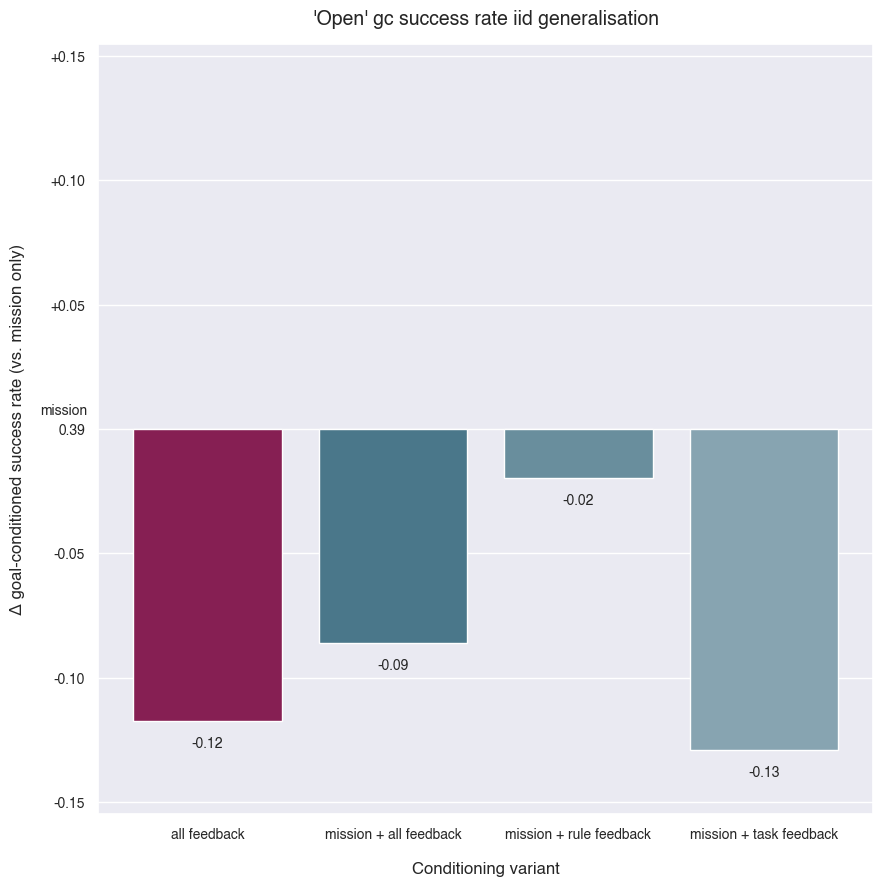

,conditioning,Mean,Std,Min,Max,ood_type,eval_type,Delta (Mean),reference
8,all feedback,0.292969,0.432569,0.0,1.0,None,ood_generalisation,0.011719,mission
7,mission + all feedback,0.296875,0.454364,0.0,1.0,None,ood_generalisation,0.015625,mission
6,mission + rule feedback,0.316406,0.447526,0.0,1.0,None,ood_generalisation,0.035156,mission
5,mission + task feedback,0.320312,0.455649,0.0,1.0,None,ood_generalisation,0.039062,mission


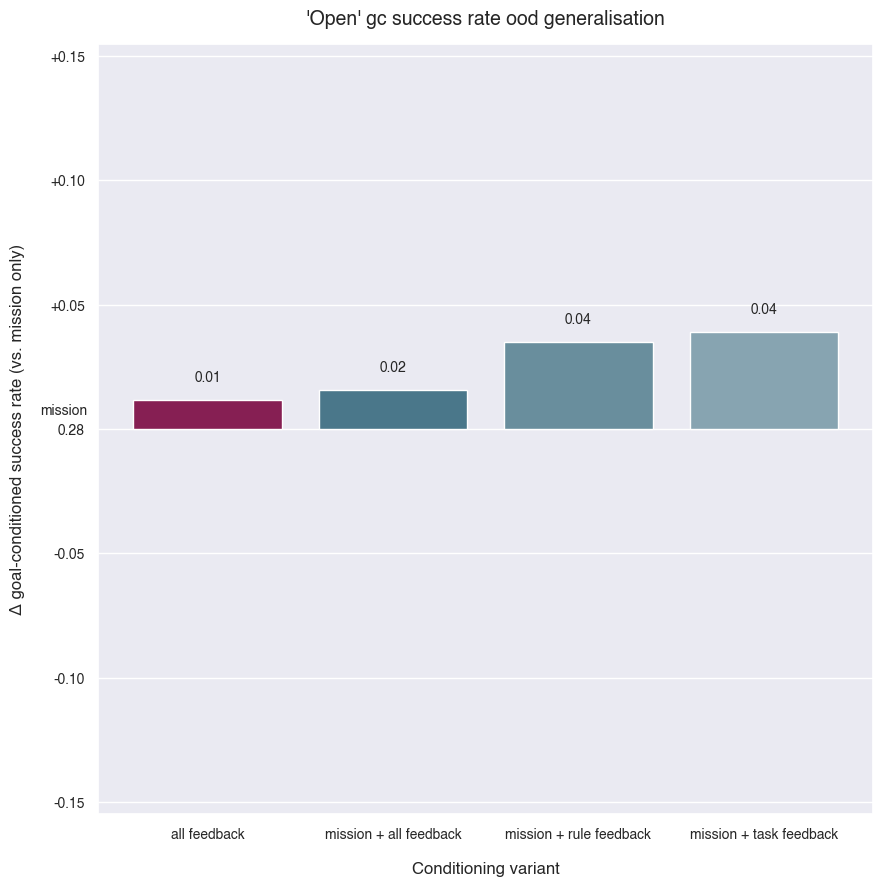

,conditioning,Mean,Std,Min,Max,ood_type,eval_type,Delta (Mean),reference
13,all feedback,0.292969,0.432569,0.0,1.0,agent_loc,ood_generalisation,0.011719,mission
12,mission + all feedback,0.296875,0.454364,0.0,1.0,agent_loc,ood_generalisation,0.015625,mission
11,mission + rule feedback,0.316406,0.447526,0.0,1.0,agent_loc,ood_generalisation,0.035156,mission
10,mission + task feedback,0.320312,0.455649,0.0,1.0,agent_loc,ood_generalisation,0.039062,mission


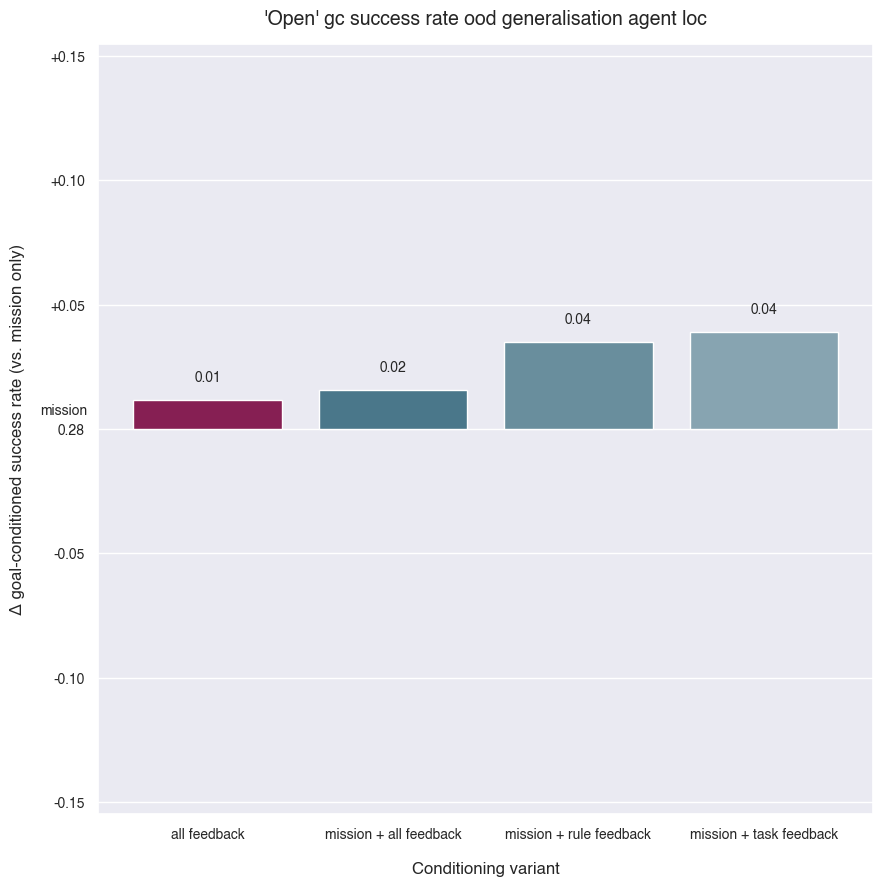

,conditioning,Mean,Std,Min,Max,ood_type,eval_type,Delta (Mean),reference
19,all feedback,0.269531,0.420453,0.0,1.0,None,iid_generalisation,-0.105469,rtg
16,rtg + all feedback,0.312500,0.439219,0.0,1.0,None,iid_generalisation,-0.062500,rtg
17,rtg + rule feedback,0.277344,0.395887,0.0,1.0,None,iid_generalisation,-0.097656,rtg
18,rtg + task feedback,0.277344,0.395887,0.0,1.0,None,iid_generalisation,-0.097656,rtg


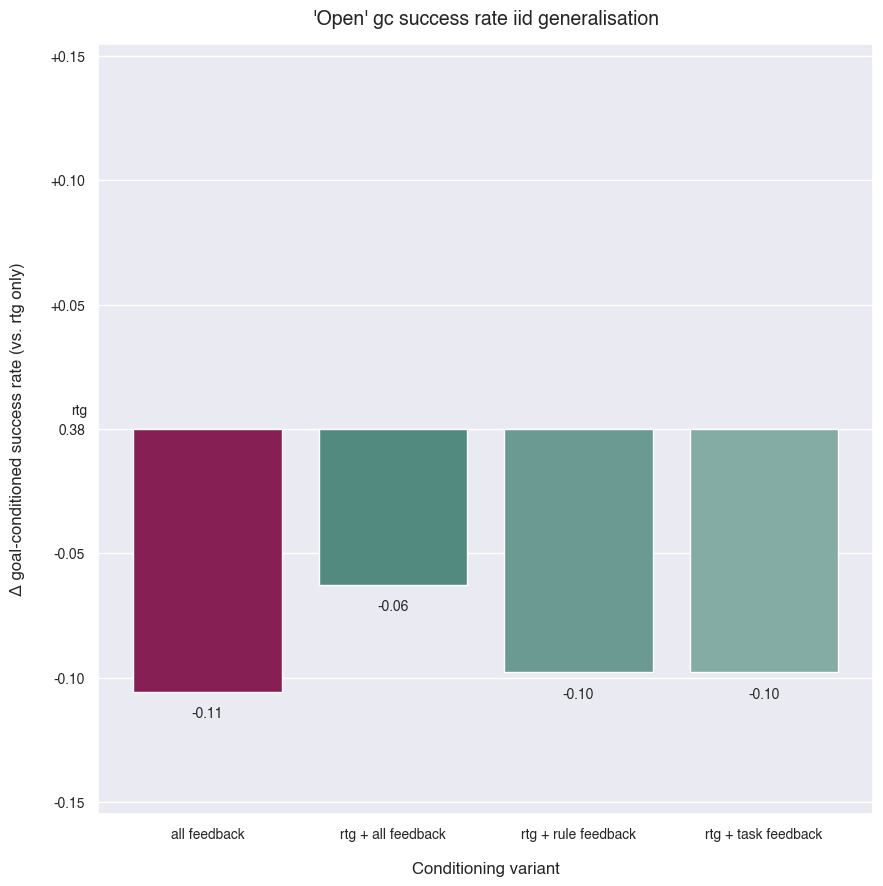

,conditioning,Mean,Std,Min,Max,ood_type,eval_type,Delta (Mean),reference
22,all feedback,0.292969,0.432569,0.0,1.0,None,ood_generalisation,-0.082031,rtg
21,rtg + all feedback,0.343750,0.442568,0.0,1.0,None,ood_generalisation,-0.031250,rtg
23,rtg + rule feedback,0.257812,0.401691,0.0,1.0,None,ood_generalisation,-0.117188,rtg
24,rtg + task feedback,0.257812,0.401691,0.0,1.0,None,ood_generalisation,-0.117188,rtg


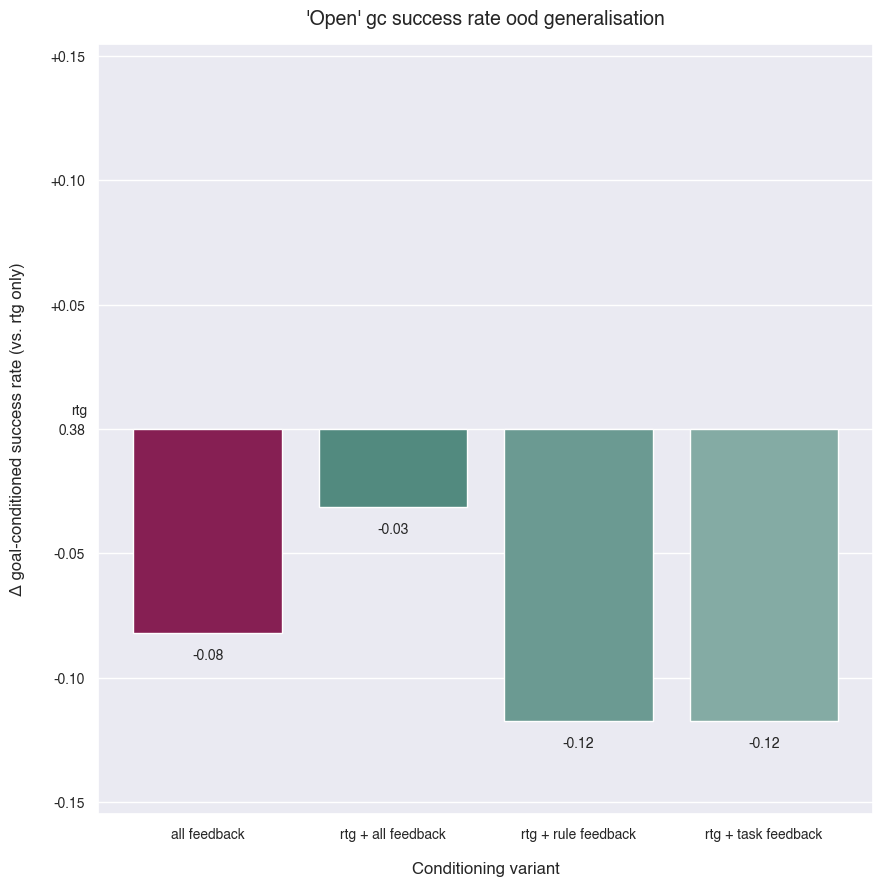

,conditioning,Mean,Std,Min,Max,ood_type,eval_type,Delta (Mean),reference
27,all feedback,0.292969,0.432569,0.0,1.0,agent_loc,ood_generalisation,-0.082031,rtg
26,rtg + all feedback,0.343750,0.442568,0.0,1.0,agent_loc,ood_generalisation,-0.031250,rtg
28,rtg + rule feedback,0.257812,0.401691,0.0,1.0,agent_loc,ood_generalisation,-0.117188,rtg
29,rtg + task feedback,0.257812,0.401691,0.0,1.0,agent_loc,ood_generalisation,-0.117188,rtg


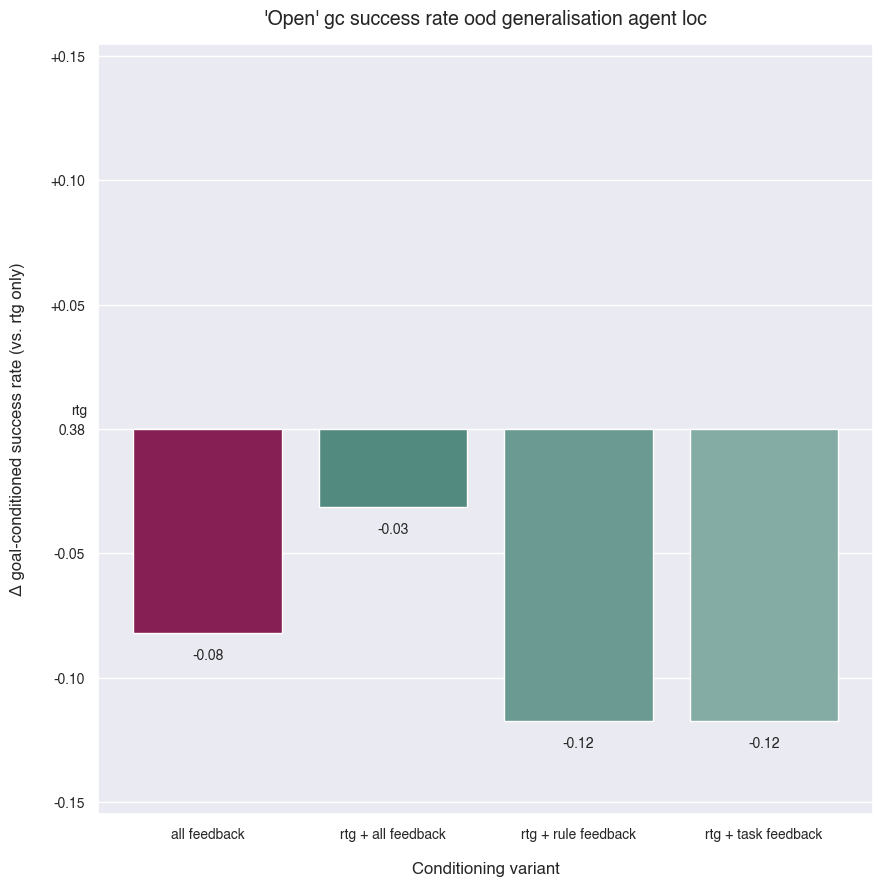

In [33]:
metric = "gc_success"
colors = {
    "aarg_colors": ["#2F8374", "#499385", "#63A297", "#7DB2A8", "#97C1BA", "#B1D1CB", "#CBE0DC", "#E5F0EE"],
    "hwu_colors": ["#970E53", "#A42C69", "#B14A7E", "#BE6894", "#CB87A9", "#D8A5BF", "#E5C3D4", "#F2E1EA"],
    "uoe_si_colors": ["#004f71", "#206583", "#407B94", "#6091A6", "#80A7B8", "#9FBDCA", "#BFD3DB", "#DFE9ED"]
}

data_home = f"{ROOT}/data/conditioning/output"
output_path = f"{ROOT}/data/conditioning/output/results"

if not os.path.exists(output_path):
    os.makedirs(output_path)

comb_df = get_combined_df(data_home)
for level in comb_df["level"].unique():
        level_df = comb_df[comb_df["level"] == level]
        results_df = combine_results(level_df, metric)
        save_results_as_csv(results_df, level, metric, output_path)
        plot_results(results_df, level, metric, colors, output_path)